# Visualise Tweet Text

These visuals can be used to justify why it is so hard to classify text: so much overlap between categories / no clear clusters! If a tweet labelled 'Economy' looks the same as a tweet labelled 'Immigration' (with regard to text), this is a difficult problem for **any** classifier: PCA, SVD, NB, SVC, LR. It is no coincidence that the PCA visual with the most distinct clusters is for Position, and the least is arguably Playfulness. These reflect the SML classifier accuracies. It is also interesting to observe that the PCA visuals of the DVs (whether a tweet was liked or shared) are also very mixed; there are no clear clusters. This might reflect the fact that content (represented by tweet text) is a far less important indicator of tweet resonance than context.

PCA is used for two purposes: to speed up ML algorithms (that are slow because the input dimension is too high) and to visualise data. I am using it for the latter. Each component represents a dimension of variation. We are interested in the components that maximise the variance.

**Resources**
- https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
- https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/PCA/PCA_Data_Visualization_Iris_Dataset_Blog.ipynb
- https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [1]:
import re
import time
import pickle
import mglearn
import pandas as pd
import numpy as np
import math
import seaborn as sns
#import pyemd
#from bhtsne import tsne
from collections import defaultdict

import os
from os import path

from io import StringIO
from IPython.display import display

from scipy import sparse as sp
from scipy.spatial import distance

#import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import matplotlib.cm as cmx
from  matplotlib.colors import Normalize

from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.manifold import *
from sklearn.decomposition import PCA, IncrementalPCA, TruncatedSVD
from sklearn.metrics.pairwise import pairwise_distances

%matplotlib inline
sns.set(font_scale=1.25)
sns.set(style='white')
sns.set(style='whitegrid', color_codes=True)
pd.options.display.max_columns = 0
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', -1)

### Load Population and Sample Tweet Files

In [2]:
filtered_tweets = os.path.expanduser('~/Dropbox/University of Oxford/Oxford Internet Institute/Dissertation/Data/population_df_with_IVs.h5')
hdf = pd.HDFStore(filtered_tweets)
df = hdf["tweets"]

In [3]:
sample_tweets = os.path.expanduser('~/Dropbox/University of Oxford/Oxford Internet Institute/Dissertation/Data/4000_sample_v5.csv')
sample_df = pd.read_csv(sample_tweets)

sample_df['issue_id'] = sample_df['issue'].factorize()[0]
sample_df['issue_binary'] = np.where(sample_df.issue != 'None', 1, 0)
sample_df['emotion_binary'] = np.where((sample_df.enthusiasm == 1) | (sample_df.anxiety == 1) | (sample_df.aversion == 1), 1, 0)
sample_df['text_no_urls'] = sample_df.text.map(lambda x: re.sub(r"http\S+", "", x))
sample_df.head(2)

tweet_id           created_at        date  day_numeric        day      time  hour hour_binned  days_before_ref  account_age              source  in_reply_to_user_id coordinates                                                        tweet_url                                                                                                                                         text           user_name user_screen_name                                                                                                                                              user_description  user_verified  user_followers_count  user_friends_count user_created_at        user_location user_time_zone  user_statuses_count  user_favourites_count                             hashtags  hashtags_count            mentions  mentions_count urls  urls_count  urls_count_binary media_urls  media_type_count  media_type_count_binary media_type  photo  video  gif position  institution    message_type  message_format  question  enthusiasm  anxiety  aversion  resolution  playfulness     issue                                                notes  rt_count_api  like_count_api  rt_count  like_count  rt_count_binary  like_count_binary  issue_id  issue_binary  emotion_binary                                                                                                                                 text_no_urls
0  735586419721293824  2016-05-25 22:40:43  2016-05-25  2            Wednesday  22:40:43  23    Night      29.00            7.03          Twitter for iPhone nan                   NaN         https://www.twitter.com/SAYNO2EU/status/735586419721293824       Young people of these Beautiful British Islands, please make sure you're registered to vote in the #EUreferendum #VoteLEAVE                  #VoteLeaveEU        SAYNO2EU         Britain is STRONGER OUT of the EU #VoteLeave #BREXIT                                                                                                          False         14358.00              7327.00              2009-05-17      NaN                  Casablanca    95.00                53.00                   ['eureferendum', 'voteleave']       2.00             []                 0.00             []  0.00         0                  []        0.00               0                        []         0      0      0    Leave    0            Identification  0               0         1           0        0         1           0            None      Page doesn't exist.                                 nan           nan             1.00      0.00         1                0                  0         0             1               Young people of these Beautiful British Islands, please make sure you're registered to vote in the #EUreferendum #VoteLEAVE                
1  741004645431189504  2016-06-09 21:30:49  2016-06-09  3            Thursday   21:30:49  22    Night      14.00            6.82          Twitter for iPhone nan                   NaN         https://www.twitter.com/BenMacpherson/status/741004645431189504  .@NicolaSturgeon - in an interdependent world, independent countries should work together for the common good. #ITVEURef #EUref #VoteRemain  Ben Macpherson MSP  BenMacpherson    Local MSP for Edinburgh Northern & Leith (@theSNP). Passionate about justice & progress. Scot & internationalist. Email: ben.macpherson.msp@parliament.scot.  False         2350.00               2106.00              2009-08-13      Edinburgh, Scotland  Edinburgh     2332.00              938.00                  ['itveuref', 'euref', 'voteremain'] 3.00             ['NicolaSturgeon'] 1.00             []  0.00         0                  []        0.00               0                        []         0      0      0    Remain   1            Identification  1               0         1           0        0         0           0            Security  User is an MSP - Member of the Scottish Parliament. 17.00         15.00           17.00     13.00        1             

In [4]:
sample_df['text_no_urls'].head()

0    Young people of these Beautiful British Islands, please make sure you're registered to vote in the #EUreferendum #VoteLEAVE                
1    .@NicolaSturgeon - in an interdependent world, independent countries should work together for the common good. #ITVEURef #EUref #VoteRemain
2    We #VoteLeave to finally stop the EU taking the piss out of us. We know we're not #StrongerIn. We know Dave doesn't care about the people. 
3    According to Angela Eagle we are not in the EU. Serious gaff. Up their with Gordon Brown's we saved the world comment. #VoteLeave          
4    I've watched the TV debates and would like to remain in the EU #CatsAgainstBrexit #kittensagainstbrexit                                    
Name: text_no_urls, dtype: object

In [5]:
df = sample_df
print(df.shape)
print(df.columns)

(2976, 62)
Index(['tweet_id', 'created_at', 'date', 'day_numeric', 'day', 'time', 'hour',
       'hour_binned', 'days_before_ref', 'account_age', 'source',
       'in_reply_to_user_id', 'coordinates', 'tweet_url', 'text', 'user_name',
       'user_screen_name', 'user_description', 'user_verified',
       'user_followers_count', 'user_friends_count', 'user_created_at',
       'user_location', 'user_time_zone', 'user_statuses_count',
       'user_favourites_count', 'hashtags', 'hashtags_count', 'mentions',
       'mentions_count', 'urls', 'urls_count', 'urls_count_binary',
       'media_urls', 'media_type_count', 'media_type_count_binary',
       'media_type', 'photo', 'video', 'gif', 'position', 'institution',
       'message_type', 'message_format', 'question', 'enthusiasm', 'anxiety',
       'aversion', 'resolution', 'playfulness', 'issue', 'notes',
       'rt_count_api', 'like_count_api', 'rt_count', 'like_count',
       'rt_count_binary', 'like_count_binary', 'issue_id', 'issue_bina

### Vectorize Tweet Text and Visualise Vectors

CountVectorizer default settings: all words are made lowercase, punctuation is ignored (#s and @s are stripped), emoji are stripped, and UTF-8 encoding is used. Extra preprocessing: include bigrams, exclude stopwords, all words have to appear at least three times and contain at least three characters. While bigrams increases dimensions, all other steps significantly reduce the number of dimensions. With PCA the number of dimensions will be further reduced to two.

It is best practise to standardise data onto a unit scale (mean = 0 and SD = 1) before applying PCA, as PCA yields a feature subspace that maximises the variance along the axes. However, sparse matrices cannot be centred, so mean is not used. The resulting visualisations are far too sparse. Moreover, my features are tf-idf vectors, and they are all measured on the same scale - in fact, after transformation to a numpy array, tf-idf scores are normalised to values between 0 and 1. Standardisation is more important when PCA is applied to ML algorithms.

Documentation: http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py

The most frequent words in the corpus have the lowest IDF scores; the least frequent words have the highest IDF scores. TF-IDF scores take both document frequency (which increases the score) and corpus frequency (which decreases the score) into account. 

**Note**: the 15 highest IDF scores are misleading because 696 tokens have an IDF score of 7.61237699989588. Every time the df is regenerated, the top 15 tokens change. The 15 lowest TF-IDF scores have very subtle differences: the lowest 11 have a TF-IDF of 0.249573411076678; the next 9 have a TF-IDF of 0.249979362737781.

In [6]:
tweet_text = df['text_no_urls']
vectorizer = CountVectorizer(ngram_range=(1,2), stop_words='english', min_df=3, token_pattern=r'\b[A-Za-z0-9]{3,}\b')
X = vectorizer.fit_transform(tweet_text)
transformer = TfidfTransformer(smooth_idf=False)
tfidf = transformer.fit_transform(X)
#tfidf_scaled = StandardScaler(with_mean=False).fit_transform(tfidf)
tfidf.shape

(2976, 2243)

In [7]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), stop_words='english', min_df=3, token_pattern=r'\b[A-Za-z0-9]{3,}\b')
tfidf_vect.fit(tweet_text)
token_idfs = dict(zip(tfidf_vect.get_feature_names(), tfidf_vect.idf_))

In [8]:
idf_df = pd.DataFrame.from_dict(token_idfs, orient='index').reset_index()
idf_df.columns = ('token', 'idf')
idf_df = idf_df.sort_values(by='idf', ascending=False)
#idf_df.to_csv("sample_idf.csv")
idf_df.head()

token  idf
1121  duncan    7.61
1889  sensible  7.61
1860  bid       7.61
1857  increases 7.61
1855  looks     7.61

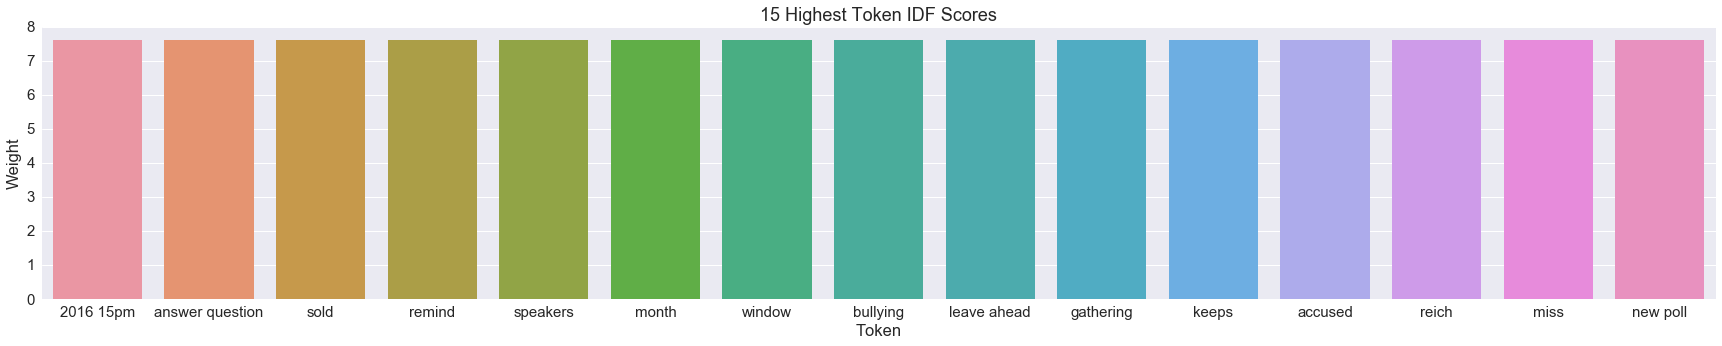

In [20]:
sns.set(font_scale=1.5)
sns.barplot(x='token', y='idf', data=idf_df.head(15))           
plt.title('15 Highest Token IDF Scores')
plt.xlabel('Token')
plt.ylabel('Weight')
fig = plt.gcf()
fig.set_size_inches(30, 5)
plt.show()
fig.savefig('Highest IDFs.jpg', bbox_inches='tight')

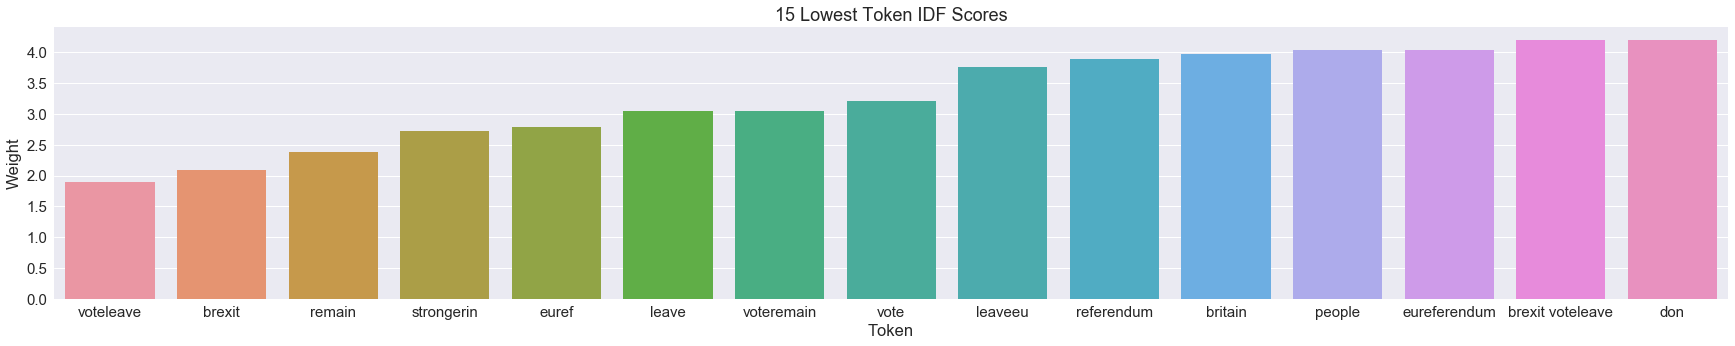

In [21]:
idf_df = idf_df.sort_values(by='idf', ascending=True)
sns.barplot(x='token', y='idf', data=idf_df.head(15))           
plt.title('15 Lowest Token IDF Scores')
plt.xlabel('Token')
plt.ylabel('Weight')
fig = plt.gcf()
fig.set_size_inches(30, 5)
plt.show()
fig.savefig('Lowest IDFs.jpg', bbox_inches='tight')

In [22]:
feature_names = np.array(tfidf_vect.get_feature_names()) 
sorted_by_idf = np.argsort(tfidf_vect.idf_) 
print("Features with lowest idf: {}".format(feature_names[sorted_by_idf[:3]]))
print("Features with highest idf: {}".format(feature_names[sorted_by_idf[-3:]]))

Features with lowest idf: ['voteleave' 'brexit' 'remain']
Features with highest idf: ['michael howard' 'lies voteleave' 'lefty']


In [23]:
max_scores = tfidf.max(axis=0).toarray().ravel() # Maximum TF-IDF scores for tokens throughout the entire dataset.
sorted_by_tfidf = max_scores.argsort() # Sort token weights from smallest to largest and extract their indices. 
print("Features with lowest tfidf: {}".format(feature_names[sorted_by_tfidf[:3]]))
print("Features with highest tfidf: {}".format(feature_names[sorted_by_tfidf[-3:]]))

Features with lowest tfidf: ['gov younusalgohar' 'britainfirst pegida' 'message british']
Features with highest tfidf: ['bremain' 'remain' 'voteremain']


In [26]:
token_tfidfs = dict(zip(feature_names, max_scores))
tfidf_df = pd.DataFrame.from_dict(token_tfidfs, orient='index').reset_index()
tfidf_df.columns = ('token', 'tfidf')
tfidf_df = tfidf_df.sort_values(by='tfidf', ascending=False)
#tfidf_df.to_csv("sample_tfidf.csv")
tfidf_df.head(5)

token  tfidf
2196  campaigning  1.00  
1942  voteleave    1.00  
1889  leadnotleave 1.00  
1254  day          1.00  
2182  remain       1.00

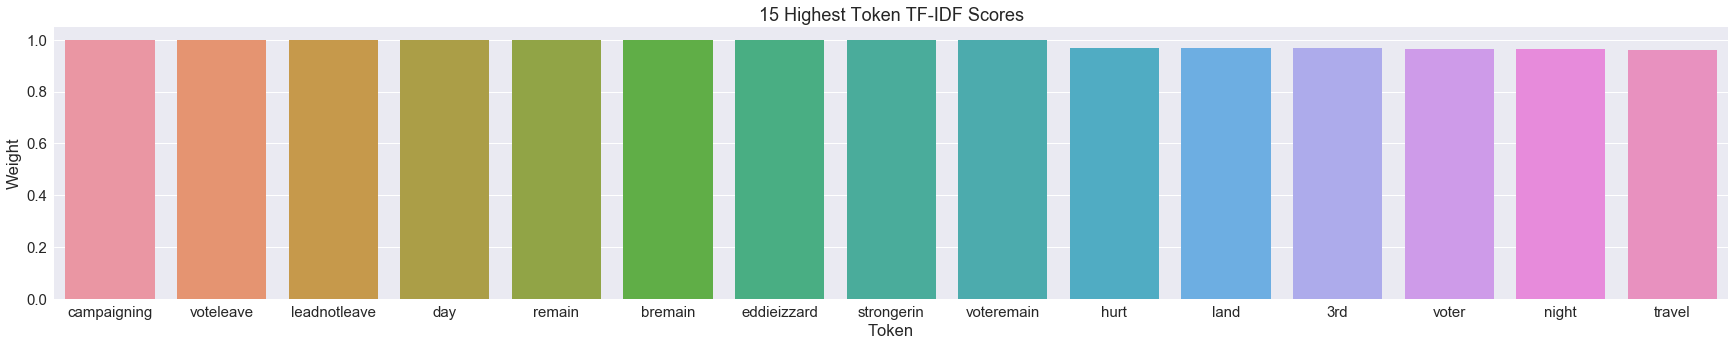

In [27]:
sns.barplot(x='token', y='tfidf', data=tfidf_df.head(15))           
plt.title('15 Highest Token TF-IDF Scores')
plt.xlabel('Token')
plt.ylabel('Weight')
fig = plt.gcf()
fig.set_size_inches(30, 5)
plt.show()
fig.savefig('Highest TF-IDFs.jpg', bbox_inches='tight')

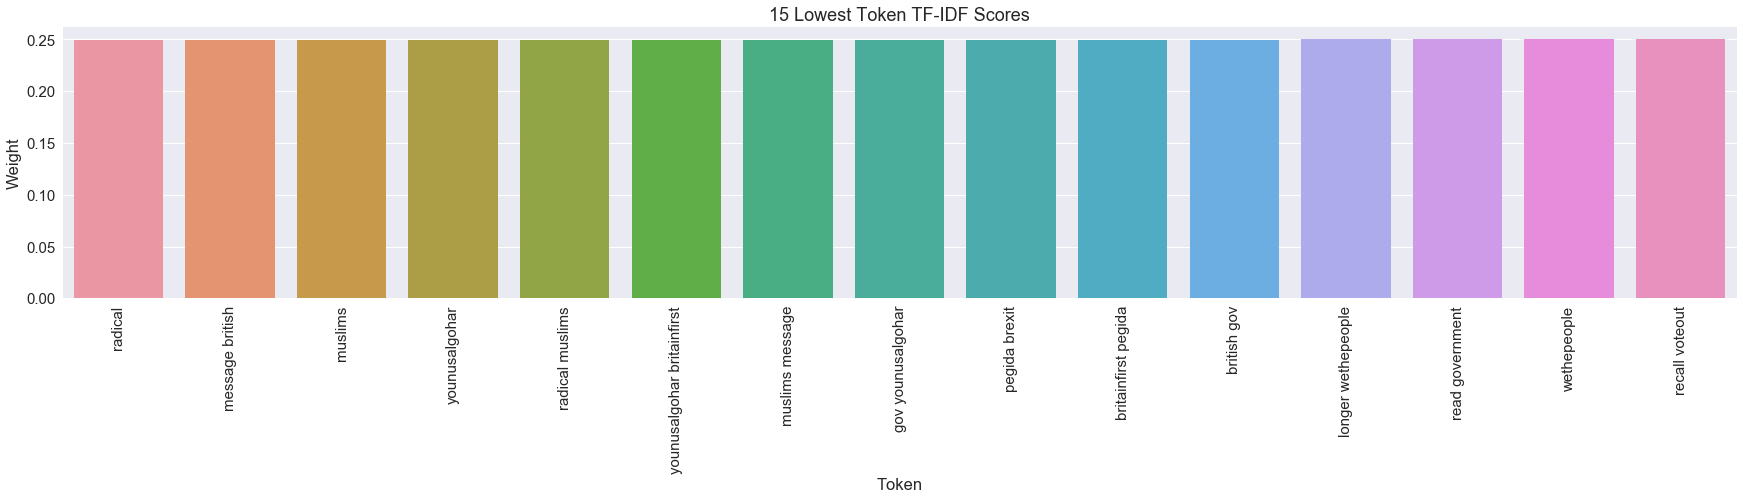

In [28]:
tfidf_df = tfidf_df.sort_values(by='tfidf', ascending=True)
sns.barplot(x='token', y='tfidf', data=tfidf_df.head(15))           
plt.title('15 Lowest Token TF-IDF Scores')
plt.xlabel('Token')
plt.ylabel('Weight')
plt.xticks(rotation='vertical')
fig = plt.gcf()
fig.set_size_inches(30, 5)
plt.show()
fig.savefig('Lowest TF-IDFs.jpg', bbox_inches='tight')

### Generate Projections from TF-IDF

#### Truncated SVD

Truncated SVD (aka Latent Semantic Analysis) performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Similar to PCA, but can work with sparse vectors more efficiently because it doesn't centre the data before computing the SVD. Text vectors are highly sparse.

Works particularly well on tf-idf matrices returned by the vectorizers in sklearn.feature_extraction.text.

Sanity check: display text of tweets plotted close to each other, to confirm that they are similar.

TruncatedSVD Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

In [51]:
svdFitter = TruncatedSVD()
svd = svdFitter.fit_transform(tfidf)
print(svd.shape)
df['svd_x'] = svd.transpose()[0]
df['svd_y'] = svd.transpose()[1]

(2976, 2)


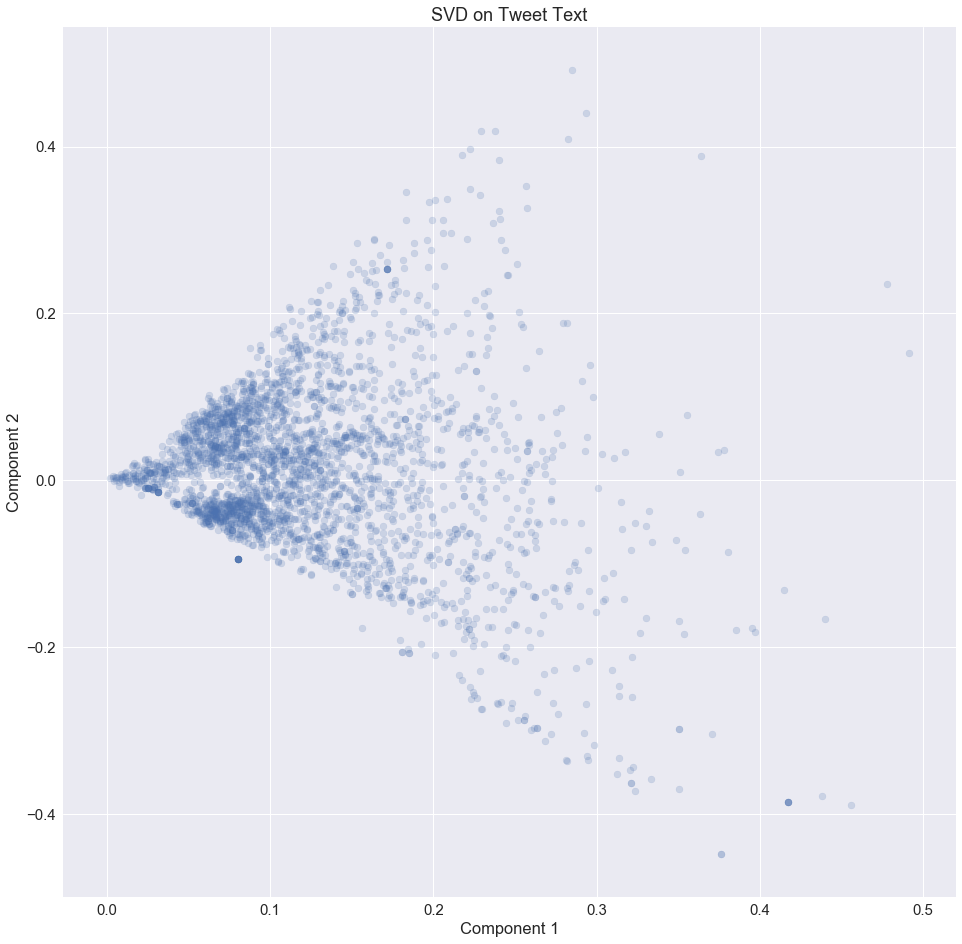

In [52]:
fig = plt.figure(figsize=(16,16))
plt.scatter(x=df['svd_x'], y=df['svd_y'], alpha=0.2)
plt.title('SVD on Tweet Text')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()
#fig.savefig('SVD on Tweet Text.jpg', bbox_inches='tight')

In [57]:
similar_svd = df[(df.svd_x < 0.15) & (df.svd_y > 0.2)]
similar_svd.sort_values('svd_x')[['text_no_urls', 'svd_x', 'svd_y']]

text_no_urls  svd_x  svd_y
867   Have been busy dropping rounds of #INtogether leaflets round to volunteers this #EalingHour. Vote remain on Thursday!                        0.11   0.21  
182   Letter through the door from Unison thus morning. Telling the other half to vote #remain                                                     0.11   0.21  
1293  IF YOU LOT VOTE #REMAIN  Be prepared for what you sow. And wait for the big told you so's.                                                   0.12   0.20  
2932  @bt_uk and others shouldn't be allowed to bully their employees to vote #remain or #leave.  #undemocratic #bullying                          0.13   0.22  
76    I think the best outcome would be a vote to #Remain but close enough to give the EU a kick in the ass it deserves.                           0.13   0.21  
1008  Final call to vote #remain tomorrow. The EU sucks, but leaving now is boost for anti-immigrant right. This by me:                            0.13   0.21  
646   #TheEUDebate - defence and security: BBC News   vote #REMAIN                                                                                 0.13   0.20  
824   #c4news A vote to #Remain would split the #Tories down the middle.  What's not to like?                                                      0.13   0.23  
1780  Why this #Bedford #Labour supporter will vote for #Remain #LabourInforBritain                                                                0.14   0.23  
992   35 Reasons to Vote #Leave  via @HuffPostUKCom                                                                                                0.14   0.21  
540   Original #TopGear trio @JeremyClarkson @RichardHammond @MrJamesMay may joke about the Germans, Italians, #EU etc but would vote #Remain #23J 0.14   0.26  
1657  To all supporters of #LEAVE and #REMAIN campaigns voting turn out is always poor The real #TRUTH is #BritainCantBeArsed Vote #SkyPizzaSofa   0.14   0.20  
2512  @LDINtogether out in force for last rally of campaign #INtogether #StrongerIn Vote to Remain for stronger, safer UK                          0.14   0.20  
1409  ! #remain #eu ?Vote for #Sardinia this #summer     #eu #strongerin #euroref                                                                  0.14   0.20  
1827  ! #remain #eu ?Vote for #Sardinia this #summer     #eu #strongerin #euroref                                                                  0.14   0.20  
729   the vast majority of #leave voters wont go vote anyway they prefer to moan on that shiity FB crap.to which i have no part ever  #remain #out 0.14   0.21  
102   Fellow Socialists & comrades who vote #Leave. I respect your decision, but can't understand it.Whatever happens, lets #remain comrades !     0.14   0.21  
1756  Love this! Vote for unity. #VoteRemain From the super talented #VictoriaToppingArtist #art #EUreferendum                                     0.15   0.20  
2846  It's not clever to gamble with the future of an entire country, pls vote remain x #VoteRemain                                                0.15   0.25

In [56]:
svd_outliers = df[(df.svd_x > 0.4) & (df.svd_y < 0.0)]
svd_outliers[['text_no_urls', 'svd_x', 'svd_y']]

...
417  ...
1263 ...
1344 ...
1421 ...
1429 ...
1742 ...
2439 ...
2616 ...
2845 ...

[9 rows x 3 columns]

#### PCA

Principal component analysis (PCA) performs linear dimensionality reduction using SVD of the data to project it to a lower dimensional space. Minimises the error globally. In order to perform PCA, the sparse tfidf vectors need to be made into a dense array. This has a large memory footprint (it will not scale to very large sets of documents).

The explained variance tells us how much information (variance) can be attributed to each of the principal components. In this case, the five components together contain only 4% of the variance! This is unsurprising, given the fact that there are 2,243 original dimensions; the vast reduction in dimensionality significantly compromises the amount of information retained.

Sanity check: display text of tweets plotted close to each other, to confirm that they are similar.

PCA Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [11]:
tfidf_dense = tfidf.toarray()
tfidf_dense.shape # Same as shape of tfidf matrix.

(2976, 2243)

In [12]:
pca = PCA(n_components=5)
pc = pca.fit_transform(tfidf_dense)
print(pc.shape)
df['pc1'] = pc.transpose()[0]
df['pc2'] = pc.transpose()[1]
df['pc3'] = pc.transpose()[2]
df['pc4'] = pc.transpose()[3]
df['pc5'] = pc.transpose()[4]
df.head()

(2976, 5)


tweet_id           created_at        date  day_numeric        day  ...    pc1   pc2   pc3   pc4   pc5
0  735586419721293824  2016-05-25 22:40:43  2016-05-25  2            Wednesday  ...  -0.04 0.00  -0.07 0.01  -0.04
1  741004645431189504  2016-06-09 21:30:49  2016-06-09  3            Thursday   ...  -0.08 0.14  0.05  0.07  -0.05
2  729211671613452288  2016-05-08 08:29:45  2016-05-08  6            Sunday     ...  0.00  0.03  0.04  -0.08 0.06 
3  741007887103864833  2016-06-09 21:43:42  2016-06-09  3            Thursday   ...  0.02  0.06  -0.03 -0.07 0.01 
4  745519782330413056  2016-06-22 08:32:21  2016-06-22  2            Wednesday  ...  -0.10 -0.07 -0.04 -0.05 0.03 

[5 rows x 67 columns]

In [13]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_) # Vector of the variance explained by each dimension.
print(pca.explained_variance_ratio_.cumsum())

[0.01056704 0.00861558 0.00811217 0.00729076 0.00649377]
[0.01073964 0.0087563  0.00824468 0.00740985 0.00659984]
[0.01073964 0.01949594 0.02774062 0.03515047 0.04175031]


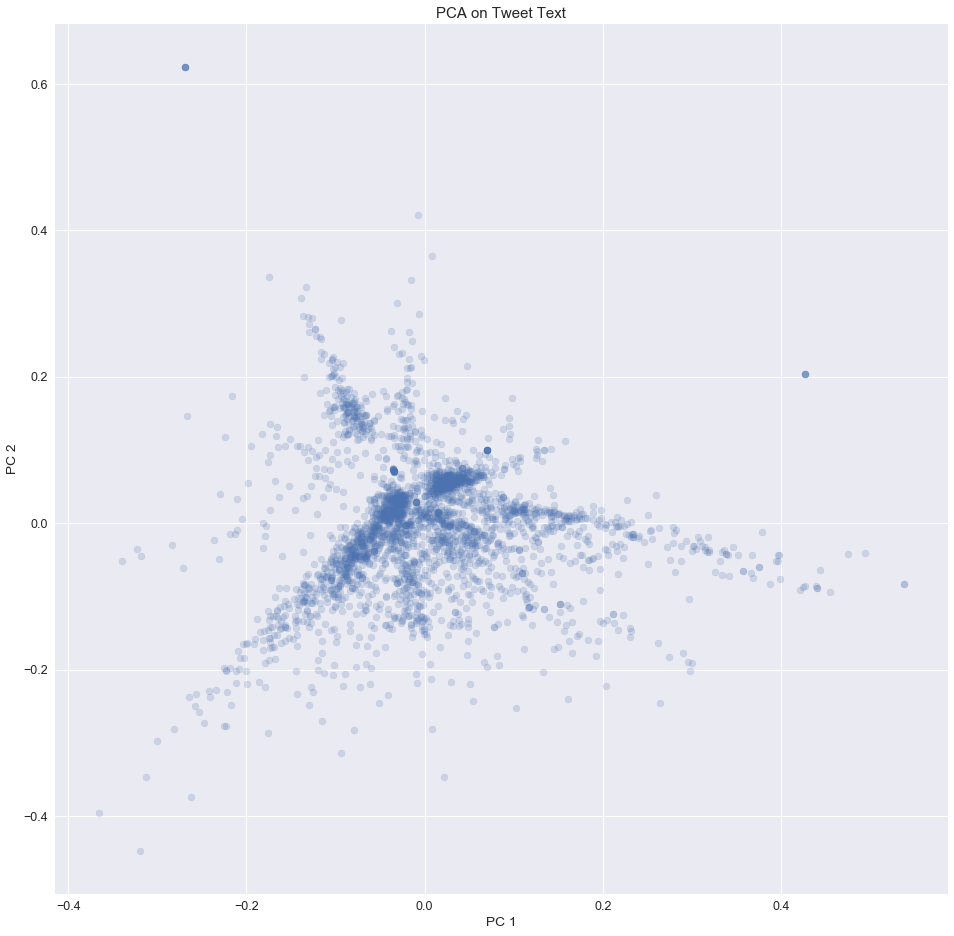

In [14]:
fig = plt.figure(figsize=(16,16))
plt.scatter(x=df['pc1'], y=df['pc2'], alpha=0.2)
plt.title('PCA on Tweet Text')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()
#fig.savefig('PCA on Tweet Text.jpg', bbox_inches='tight')

In [48]:
similar_pcs = df[(df.pc1 > 0.4) & (df.pc2 < 0.0)]
similar_pcs.sort_values('pc1')[['text_no_urls', 'pc1', 'pc2']]

text_no_urls  pc1   pc2
2685  Brexit The Movie  #EU #brexit #referendum #voteleave                             0.42 -0.09
2607  Attempt will fail. #EU #brexit #referendum #voteleave BREXIT BLOG:-              0.42 -0.09
2780  The cat is out of the bag. #EU #brexit #referendum #voteleave brexit FB page:    0.43 -0.09
2721  Get Britain Out. #EU #brexit #referendum #voteleave brexit FB page:              0.44 -0.09
399   Lord Owen. #EU #brexit #referendum #voteleave brexit FB page:                    0.44 -0.09
2623  Lord Owen. #EU #brexit #referendum #voteleave brexit FB page:                    0.44 -0.09
2885  Bill of Rights 1989. #EU #brexit #referendum #voteleave                          0.44 -0.06
2267  Is that what you want? #EU #brexit #referendum #voteleave brexit FB page:        0.45 -0.09
2439  #Voteleave #eu #brexit by therealnillian                                         0.48 -0.04
1344  I'll get me coat.   #Brexit #VoteLeave                                           0.49 -0.04
1554  Betrayed by the EU  #EU #brexit #referendum #voteleave                           0.54 -0.08
2957  It's about governing yourself. #EU #brexit #referendum #voteleave                0.54 -0.08

In [49]:
pc_outliers = df[(df.pc2 > 0.6)]
pc_outliers[['text_no_urls', 'pc2']]

text_no_urls  pc2
99    cricket wasnt too #voteremain                                                                                        0.62
566   #VoteRemain here's why:                                                                                              0.62
923   Somesuch x @LeoLeigh2 #voteremain                                                                                    0.62
1683  Done! #voteremain                                                                                                    0.62
2682  What has the EU done for us: clean beaches and rivers! Across the EU you can see ratings of all beaches. #VoteRemain 0.62
2947  I'm an #innie #VoteRemain                                                                                            0.62

#### t-SNE

t-distributed Stochastic Neighbor Embedding (TSNE) visualises high-dimensional data. Optimises the local error and requires dense vectors. Converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. Has a cost function that is not convex; i.e., with different initializations we can get different results. 

Use another dimensionality reduction method (e.g., PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g., 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples.

The Barnes-Hut implementation of t-SNE (Cython) delivers better results than scikit-learn.

Documentation: https://github.com/dominiek/python-bhtsne
<br>Scikit-learn Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [ ]:
# Need to properly import bhtsne before I can run this!
tsne = bhtsne.tsne(tfidf_dense)
print(tsne.shape)
df['tsne_x'] = tsne.transpose()[0]
df['tsne_y'] = tsne.transpose()[1]

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(x=df['tsne_x'], y=df['tsne_y'], alpha=0.2)
plt.show()

### Plot All Binary Variables

In [13]:
df.columns

Index(['tweet_id', 'created_at', 'date', 'day_numeric', 'day', 'time', 'hour',
       'hour_binned', 'days_before_ref', 'account_age', 'source',
       'in_reply_to_user_id', 'coordinates', 'tweet_url', 'text', 'user_name',
       'user_screen_name', 'user_description', 'user_verified',
       'user_followers_count', 'user_friends_count', 'user_created_at',
       'user_location', 'user_time_zone', 'user_statuses_count',
       'user_favourites_count', 'hashtags', 'hashtags_count', 'mentions',
       'mentions_count', 'urls', 'urls_count', 'urls_count_binary',
       'media_urls', 'media_type_count', 'media_type_count_binary',
       'media_type', 'photo', 'video', 'gif', 'position', 'institution',
       'message_type', 'message_format', 'question', 'enthusiasm', 'anxiety',
       'aversion', 'resolution', 'playfulness', 'issue', 'notes',
       'rt_count_api', 'like_count_api', 'rt_count', 'like_count',
       'rt_count_binary', 'like_count_binary', 'issue_id', 'issue_binary',
      

In [14]:
cols = ['institution', 'message_format', 'question', 'enthusiasm', 'anxiety', 'aversion', 
        'emotion_binary', 'resolution', 'playfulness', 'issue_binary', 'rt_count_binary', 'like_count_binary']

#### SVD

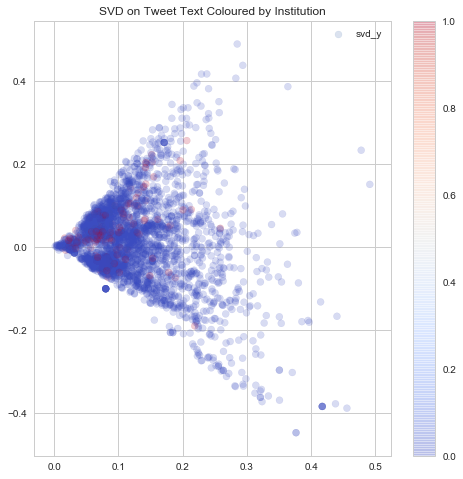

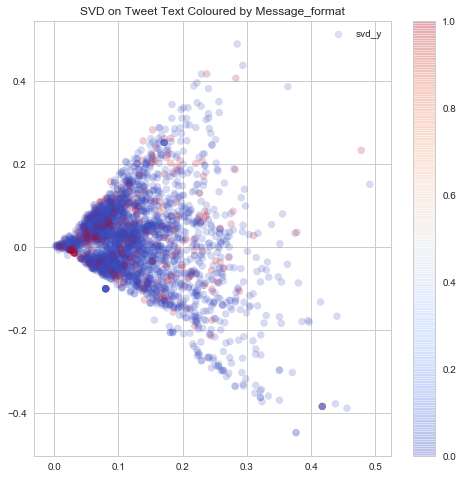

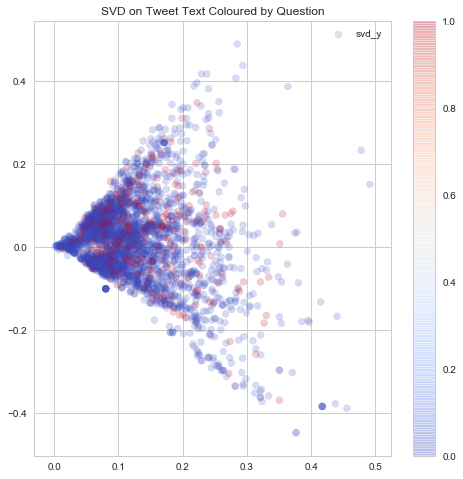

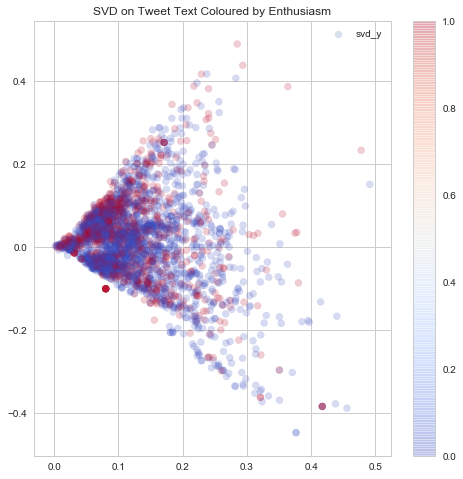

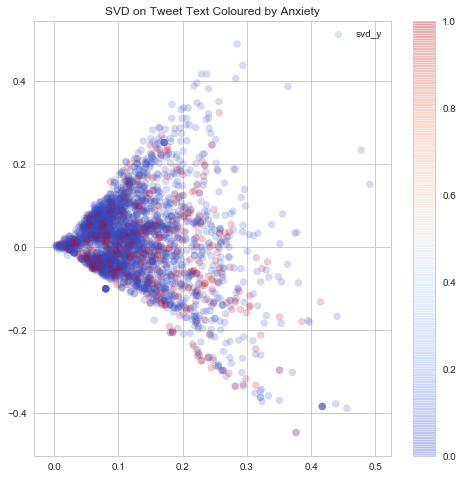

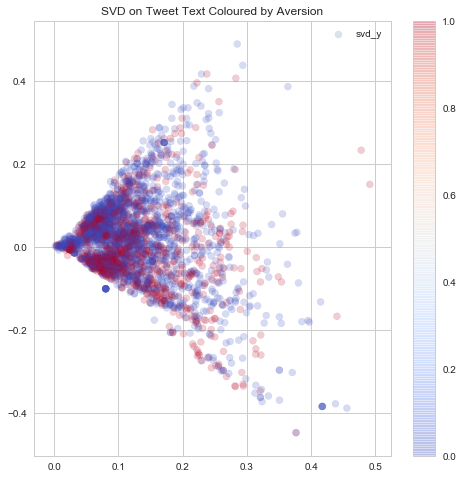

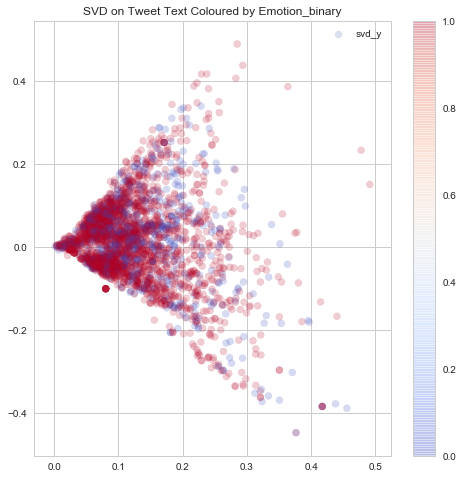

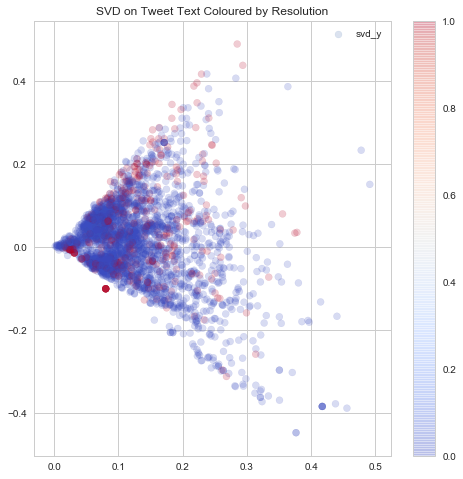

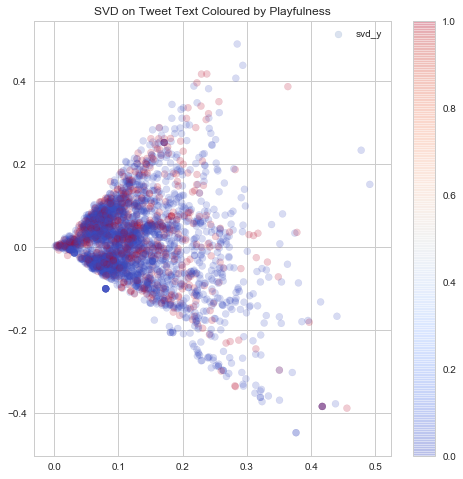

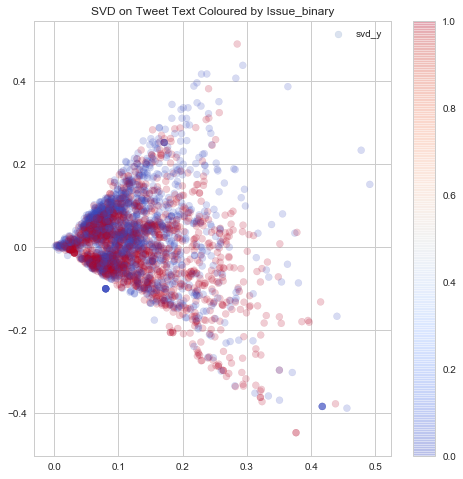

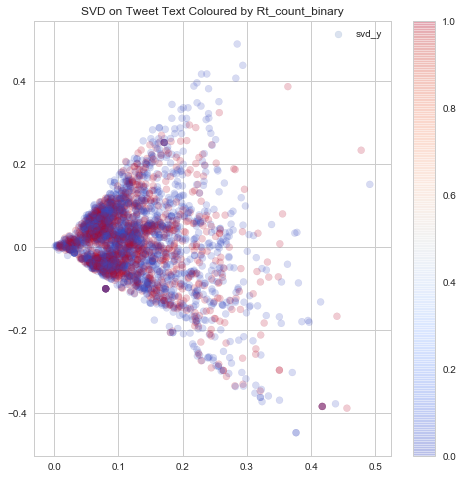

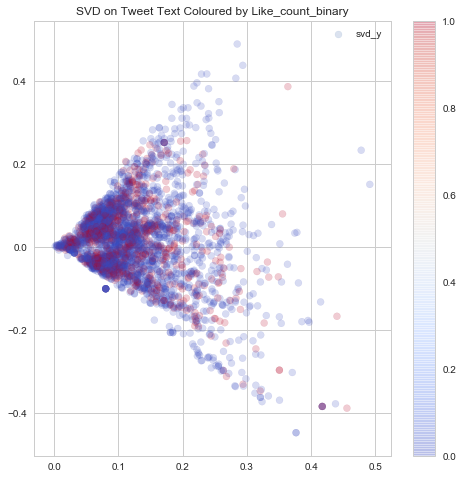

In [15]:
for col in cols:
    try:
        plt.figure(figsize=(8,8))
        plt.scatter(x=df["svd_x"], y=df["svd_y"], c=df[col], cmap="coolwarm", alpha=0.2)
        plt.title("SVD on Tweet Text Coloured by " + col.capitalize())
        plt.legend()
        plt.colorbar()
        plt.show()
    except:
        print("Unable to plot " + col)

#### PCA

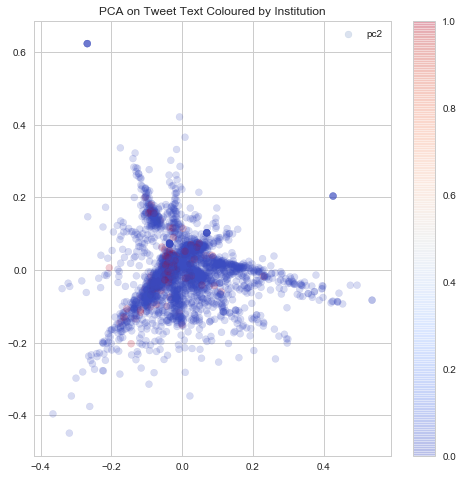

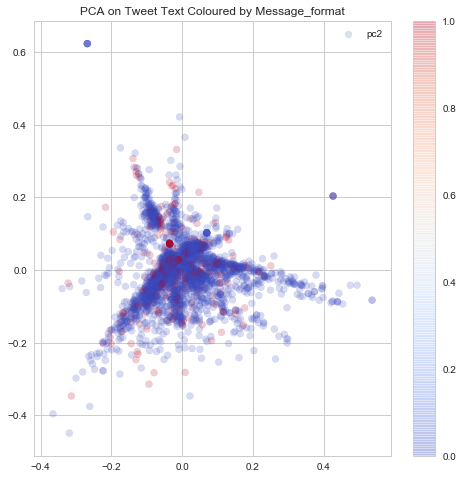

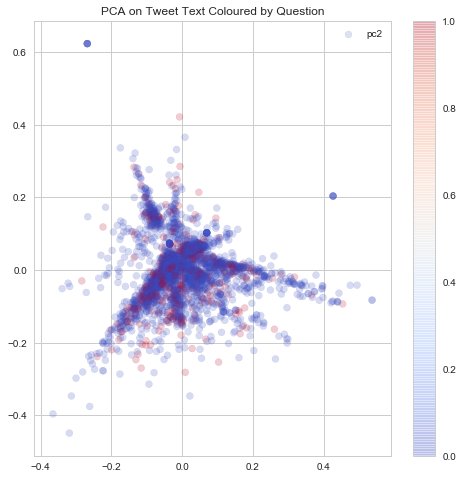

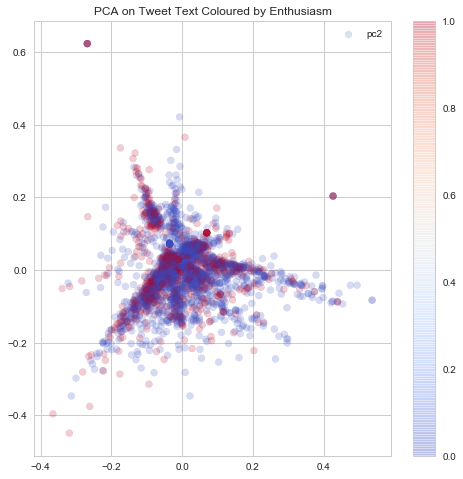

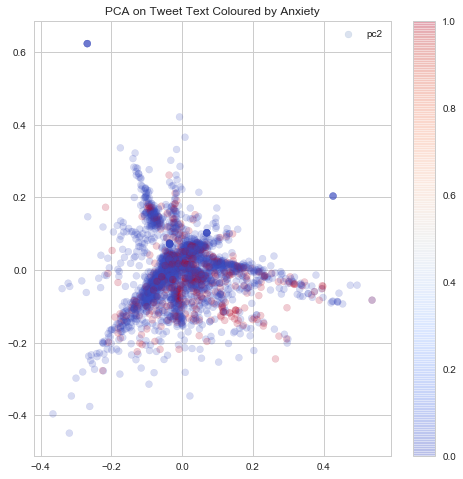

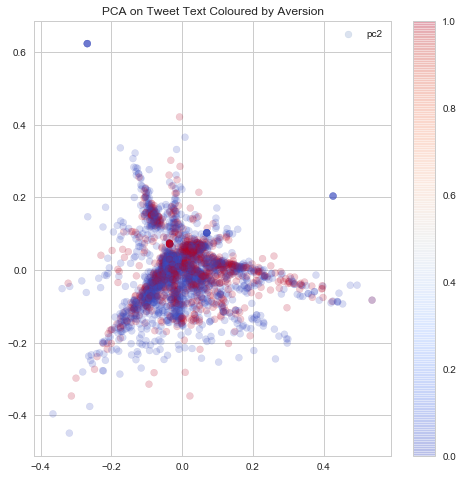

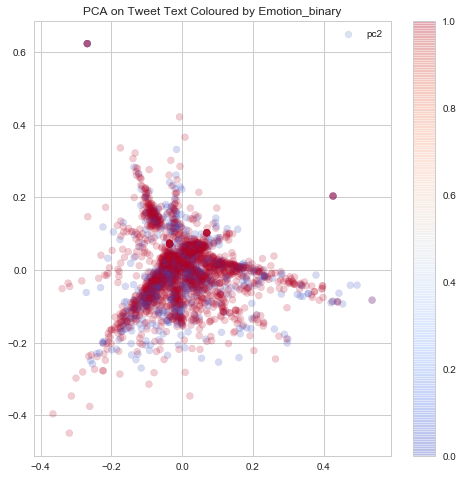

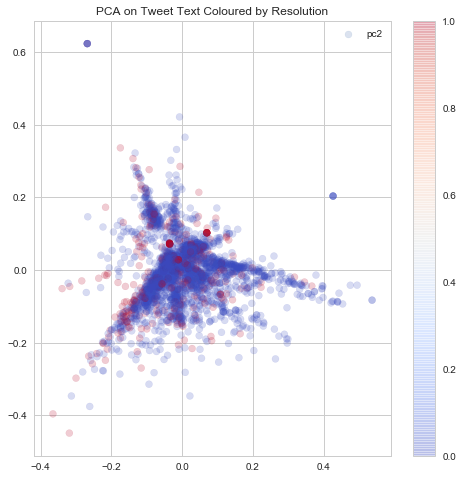

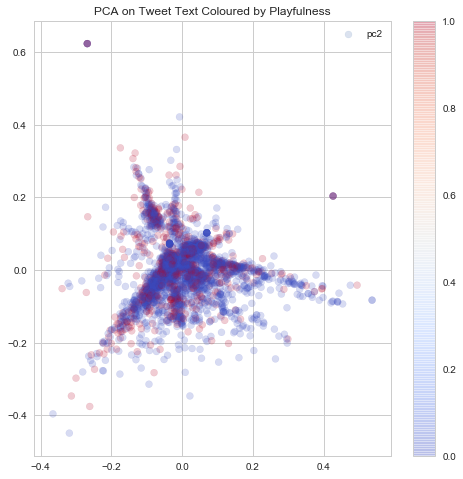

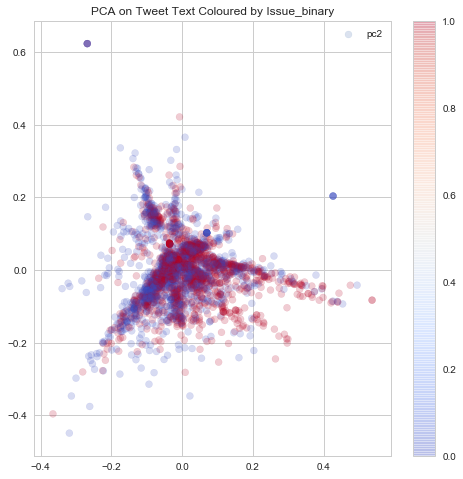

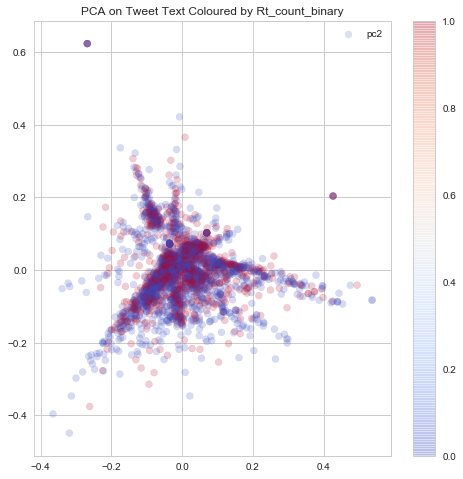

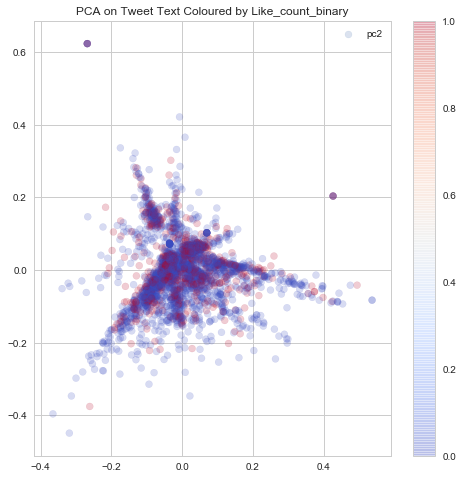

In [16]:
for col in cols:
    try:
        plt.figure(figsize=(8,8))
        plt.scatter(x=df["pc1"], y=df["pc2"], c=df[col], cmap="coolwarm", alpha=0.2)
        plt.title("PCA on Tweet Text Coloured by " + col.capitalize())
        plt.legend()
        plt.colorbar()
        plt.show()
    except:
        print("Unable to plot " + col)

#### t-SNE

In [ ]:
for col in cols:
    try:
        plt.scatter(x=df["tsne_x"], y=df["tsne_y"], c=df[col], cmap="coolwarm", alpha=0.2)
        plt.title("t-SNE on " + col)
        plt.legend()
        plt.colorbar()
        plt.show()
    except:
        print("Unable to plot " + col)

### PCA Plots

In [28]:
sns.set(font_scale=1.25)

**Issue**

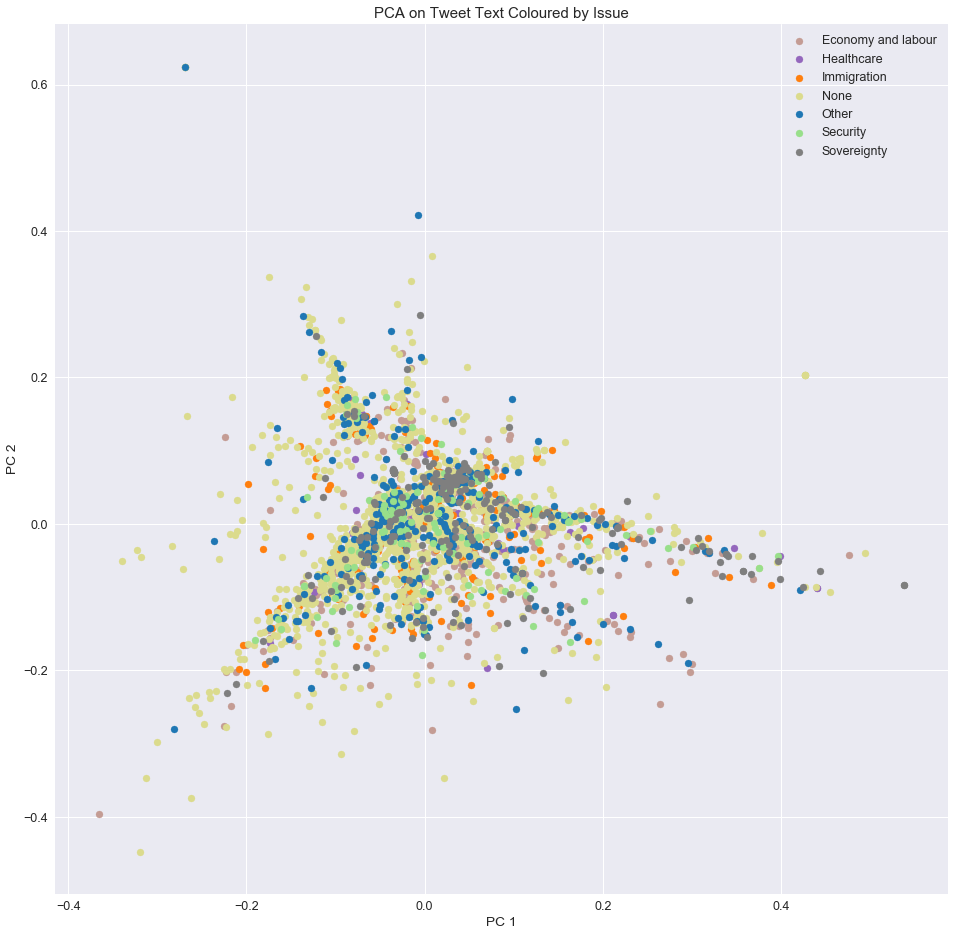

In [29]:
cm = plt.get_cmap('tab20')
cNorm = Normalize(vmin=0, vmax=len(set(df['issue'])))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
uniq = list(set(df['issue']))

fig = plt.figure(figsize=(16,16))
for name, group in df.groupby('issue'):
    plt.scatter(x=group['pc1'], y=group['pc2'], c=scalarMap.to_rgba(uniq.index(name)), label=name)
plt.title('PCA on Tweet Text Coloured by Issue')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()
fig.savefig('PCA on Tweet Text Coloured by Issue.jpg', bbox_inches='tight')

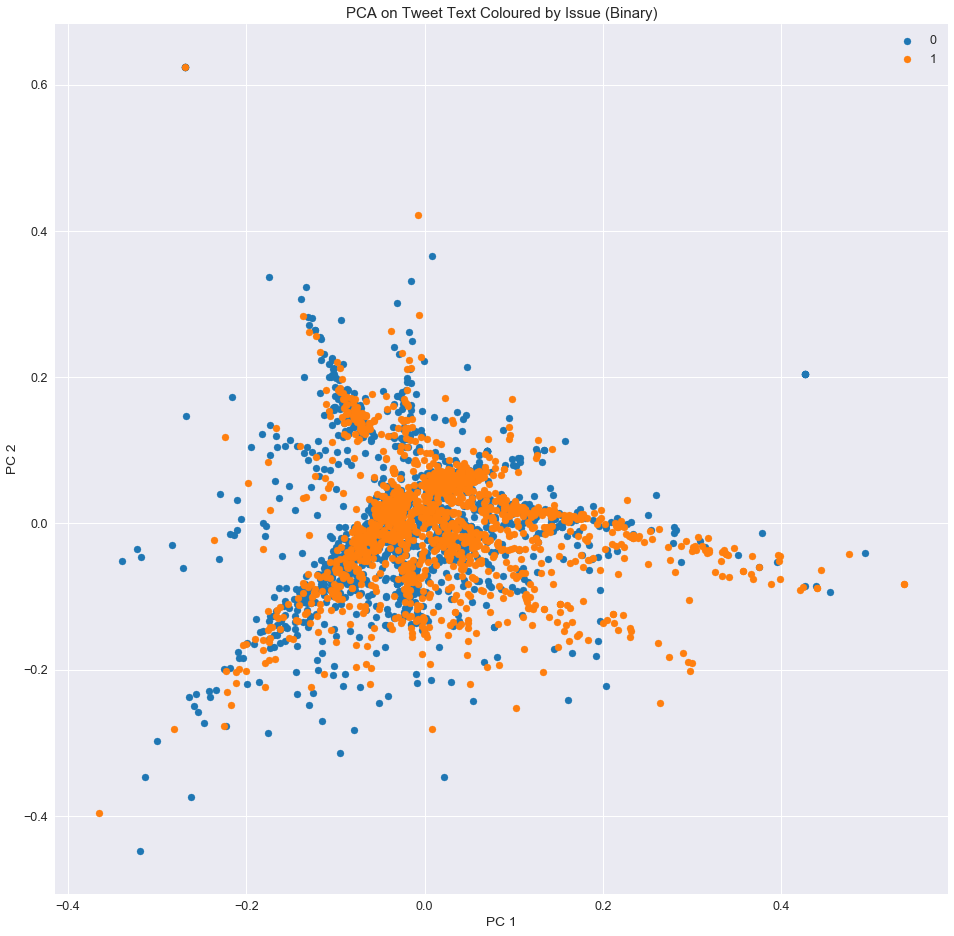

In [30]:
cNorm = Normalize(vmin=0, vmax=len(set(df['issue'])))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
uniq = list(set(df['issue_binary']))

fig = plt.figure(figsize=(16,16))
for name, group in df.groupby('issue_binary'):
    plt.scatter(x=group['pc1'], y=group['pc2'], c=scalarMap.to_rgba(uniq.index(name)), label=name)
#plt.scatter(x=df['pc1'], y=df['pc2'], c=df['issue_binary'], cmap='Paired')
plt.title('PCA on Tweet Text Coloured by Issue (Binary)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()
fig.savefig('PCA on Tweet Text Coloured by Issue (Binary).jpg', bbox_inches='tight')

**Position**

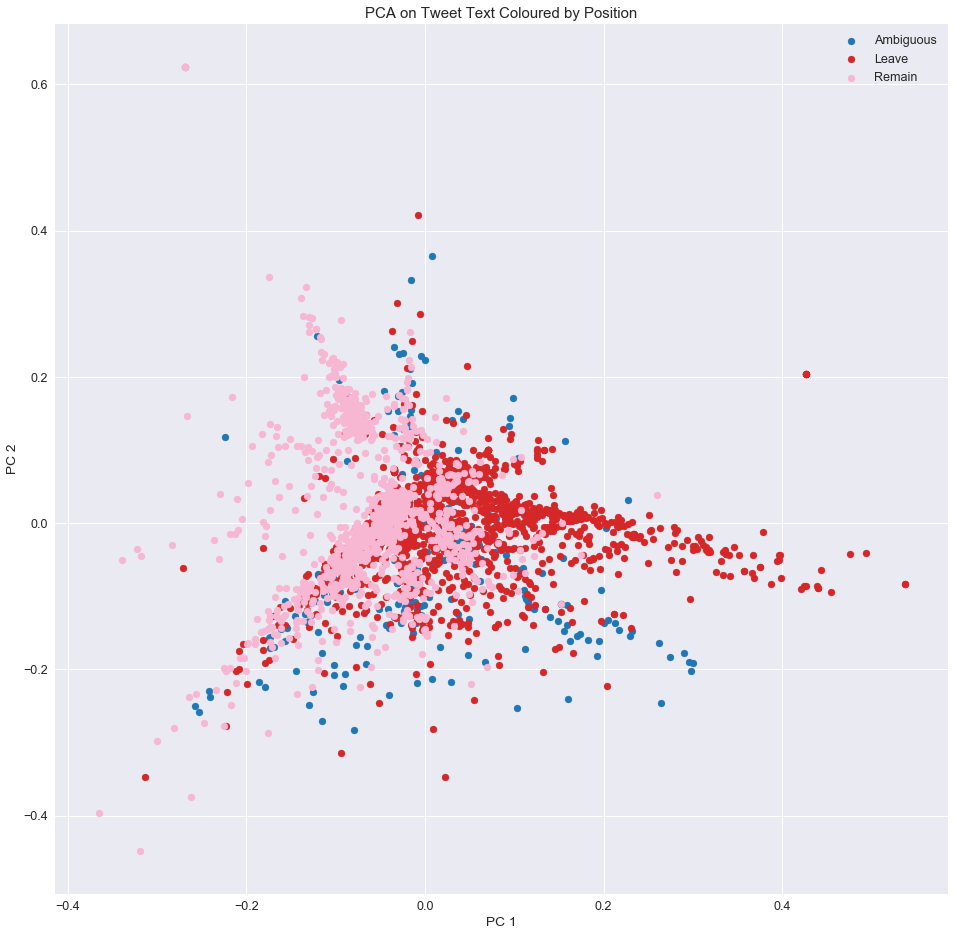

In [31]:
cNorm = Normalize(vmin=0, vmax=len(set(df['position'])))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
uniq = list(set(df['position']))

fig = plt.figure(figsize=(16,16))
for name, group in df.groupby('position'):
    plt.scatter(x=group['pc1'], y=group['pc2'], c=scalarMap.to_rgba(uniq.index(name)), label=name)
plt.title('PCA on Tweet Text Coloured by Position')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()
fig.savefig('PCA on Tweet Text Coloured by Position.jpg', bbox_inches='tight')

**Message Type**

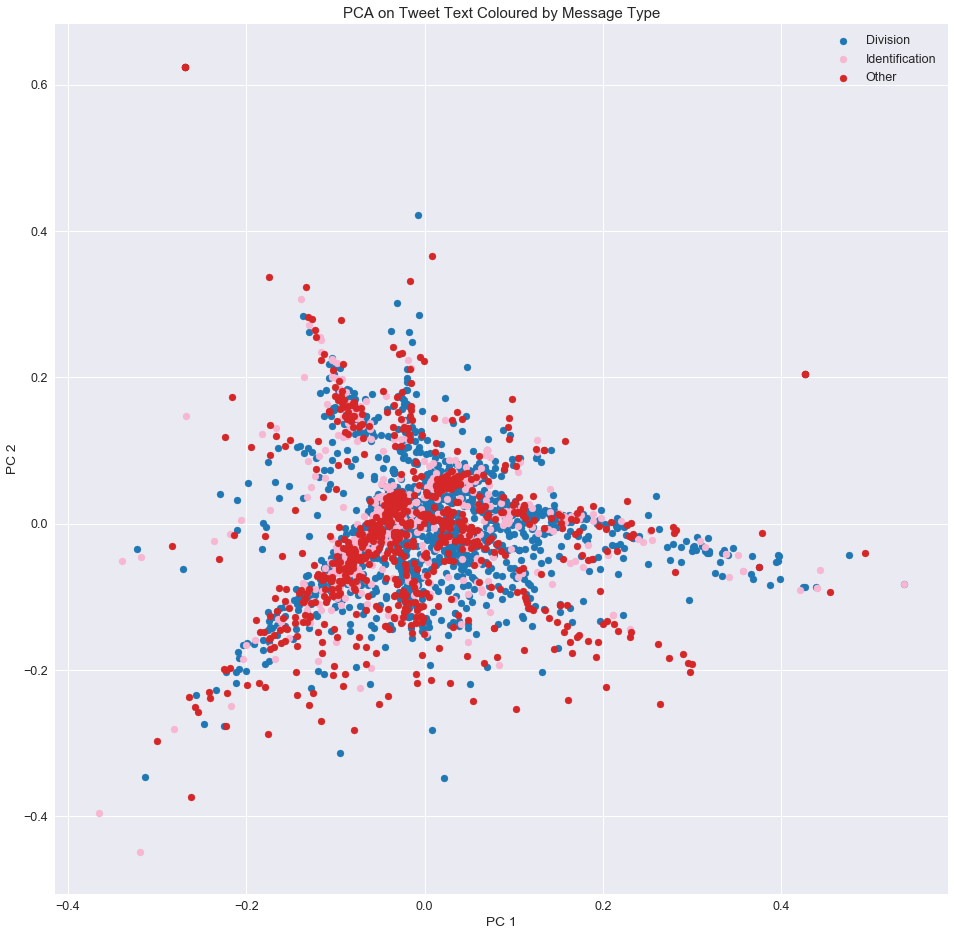

In [51]:
cNorm = Normalize(vmin=0, vmax=len(set(df['message_type'])))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
uniq = list(set(df['message_type']))

fig = plt.figure(figsize=(16,16))
for name, group in df.groupby('message_type'):
    plt.scatter(x=group['pc1'], y=group['pc2'], c=scalarMap.to_rgba(uniq.index(name)), label=name)
plt.title('PCA on Tweet Text Coloured by Message Type')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()
fig.savefig('PCA on Tweet Text Coloured by Message Type.jpg', bbox_inches='tight')

**Organisation**

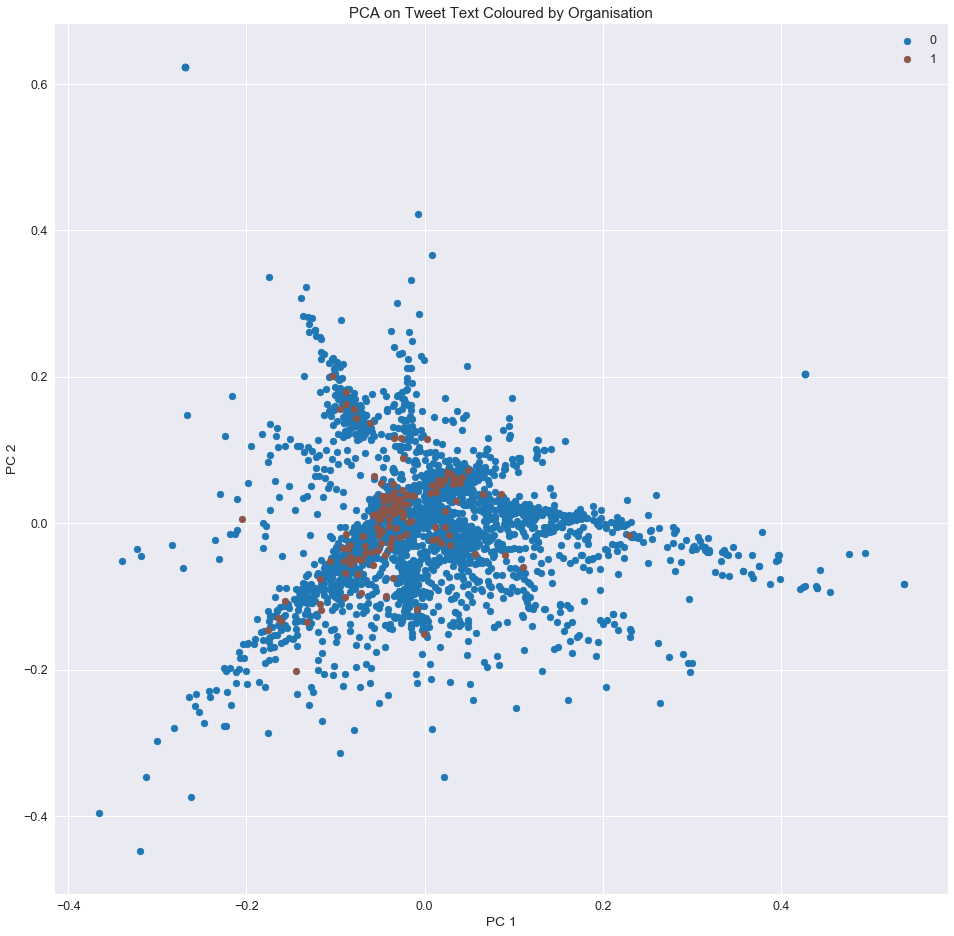

In [52]:
cNorm = Normalize(vmin=0, vmax=len(set(df['institution'])))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
uniq = list(set(df['institution']))

fig = plt.figure(figsize=(16,16))
for name, group in df.groupby('institution'):
    plt.scatter(x=group['pc1'], y=group['pc2'], c=scalarMap.to_rgba(uniq.index(name)), label=name)
plt.title('PCA on Tweet Text Coloured by Organisation')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()
fig.savefig('PCA on Tweet Text Coloured by Organisation.jpg', bbox_inches='tight')

**Enthusiasm**

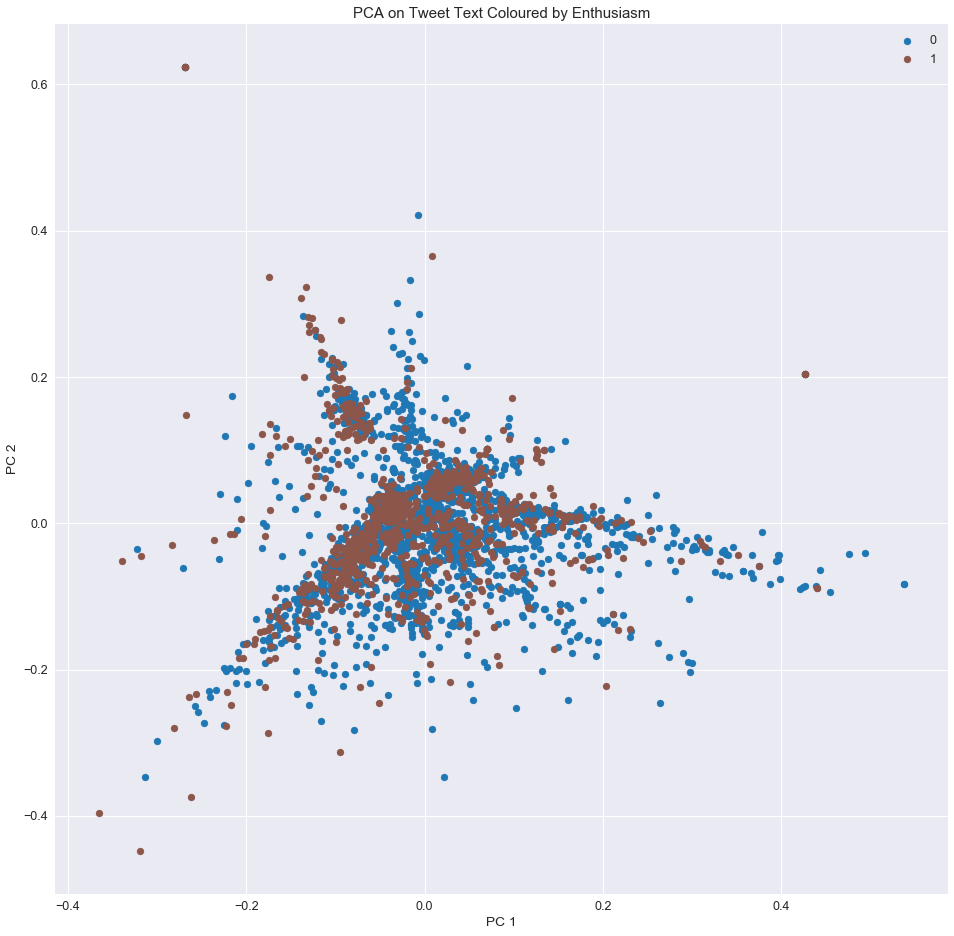

In [53]:
cNorm = Normalize(vmin=0, vmax=len(set(df['enthusiasm'])))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
uniq = list(set(df['enthusiasm']))

fig = plt.figure(figsize=(16,16))
for name, group in df.groupby('enthusiasm'):
    plt.scatter(x=group['pc1'], y=group['pc2'], c=scalarMap.to_rgba(uniq.index(name)), label=name)
plt.title('PCA on Tweet Text Coloured by Enthusiasm')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()
fig.savefig('PCA on Tweet Text Coloured by Enthusiasm.jpg', bbox_inches='tight')

**Anxiety**

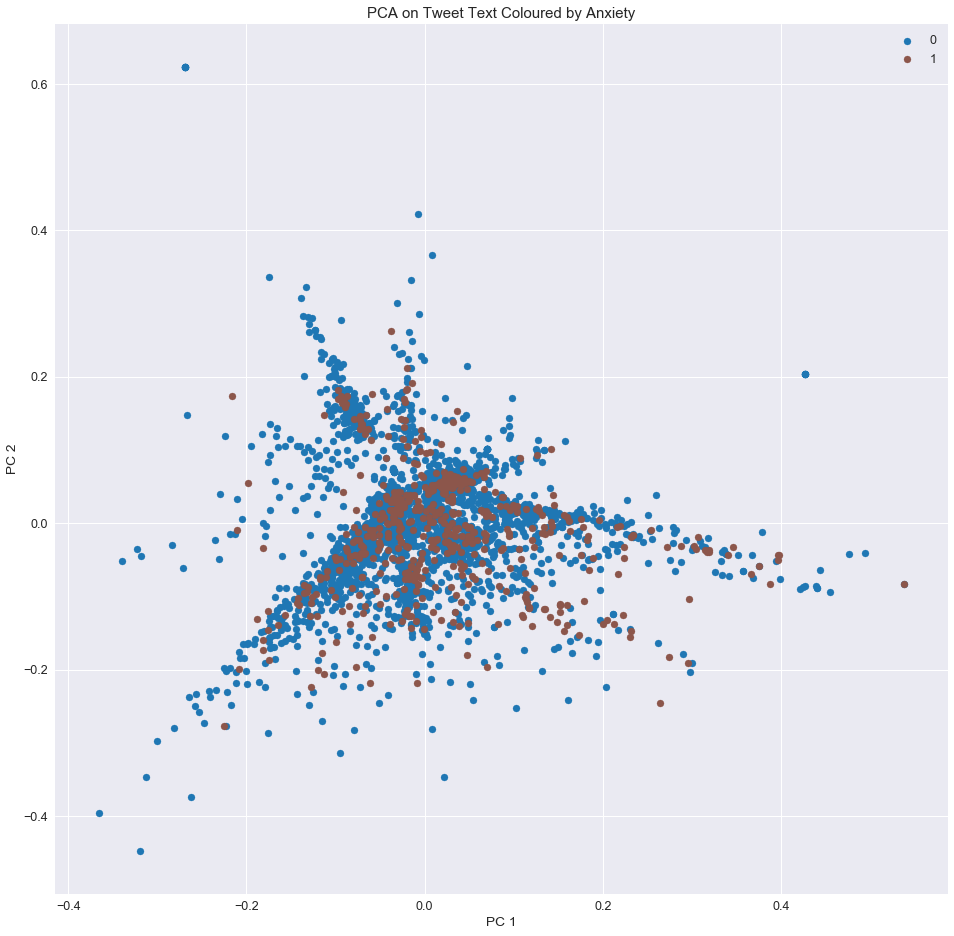

In [54]:
cNorm = Normalize(vmin=0, vmax=len(set(df['anxiety'])))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
uniq = list(set(df['anxiety']))

fig = plt.figure(figsize=(16,16))
for name, group in df.groupby('anxiety'):
    plt.scatter(x=group['pc1'], y=group['pc2'], c=scalarMap.to_rgba(uniq.index(name)), label=name)
plt.title('PCA on Tweet Text Coloured by Anxiety')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()
fig.savefig('PCA on Tweet Text Coloured by Anxiety.jpg', bbox_inches='tight')

**Aversion**

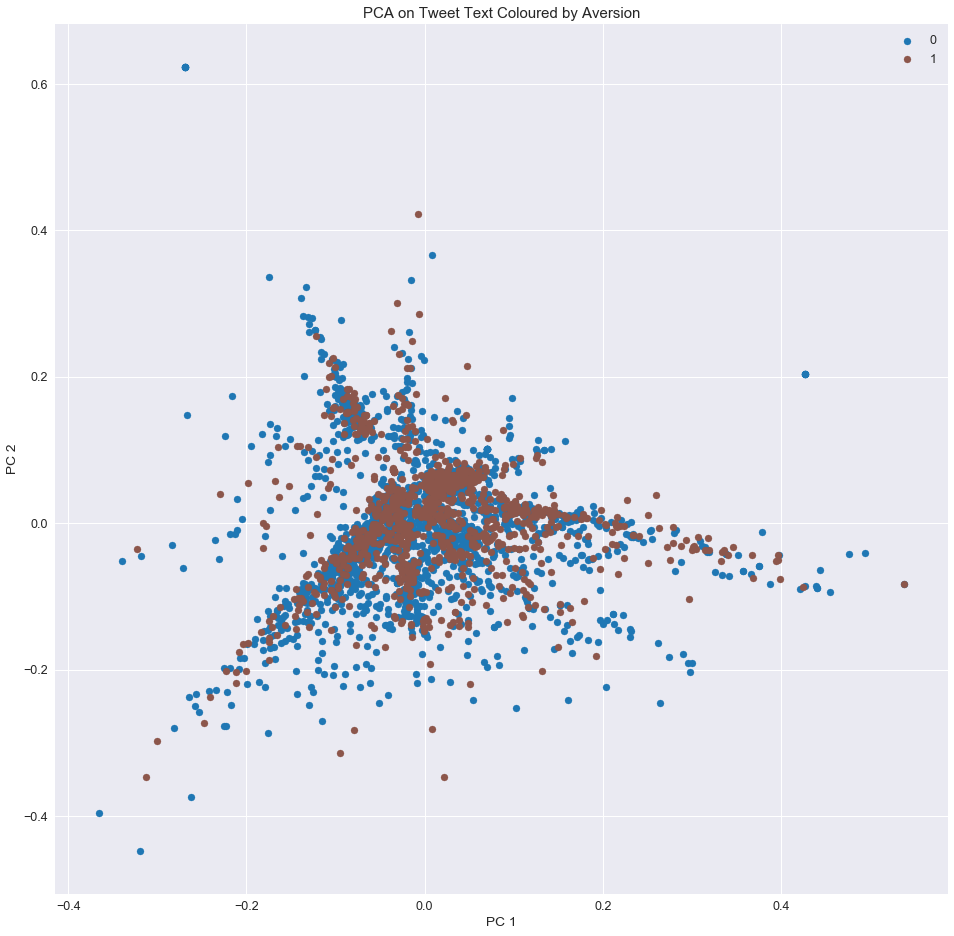

In [55]:
cNorm = Normalize(vmin=0, vmax=len(set(df['aversion'])))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
uniq = list(set(df['aversion']))

fig = plt.figure(figsize=(16,16))
for name, group in df.groupby('aversion'):
    plt.scatter(x=group['pc1'], y=group['pc2'], c=scalarMap.to_rgba(uniq.index(name)), label=name)
plt.title('PCA on Tweet Text Coloured by Aversion')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()
fig.savefig('PCA on Tweet Text Coloured by Aversion.jpg', bbox_inches='tight')

**Emotion (Binary)**

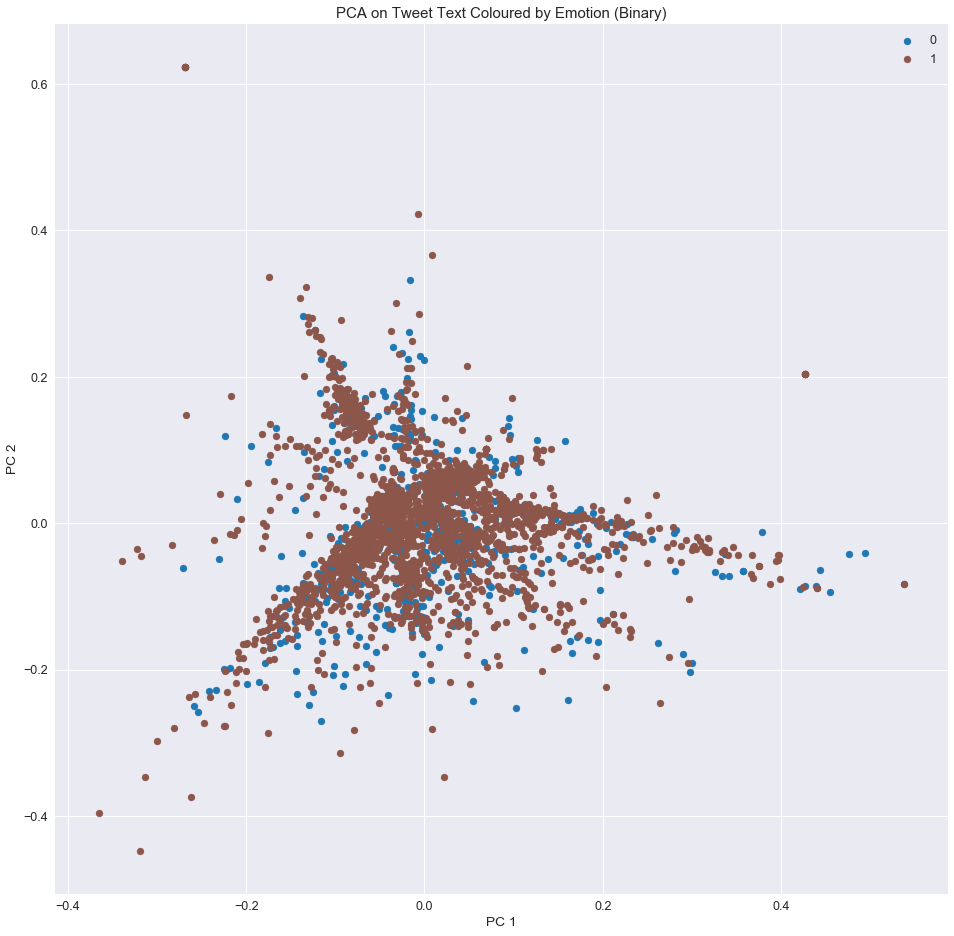

In [56]:
cNorm = Normalize(vmin=0, vmax=len(set(df['emotion_binary'])))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
uniq = list(set(df['emotion_binary']))

fig = plt.figure(figsize=(16,16))
for name, group in df.groupby('emotion_binary'):
    plt.scatter(x=group['pc1'], y=group['pc2'], c=scalarMap.to_rgba(uniq.index(name)), label=name)
plt.title('PCA on Tweet Text Coloured by Emotion (Binary)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()
fig.savefig('PCA on Tweet Text Coloured by Emotion (Binary).jpg', bbox_inches='tight')

**Resolution**

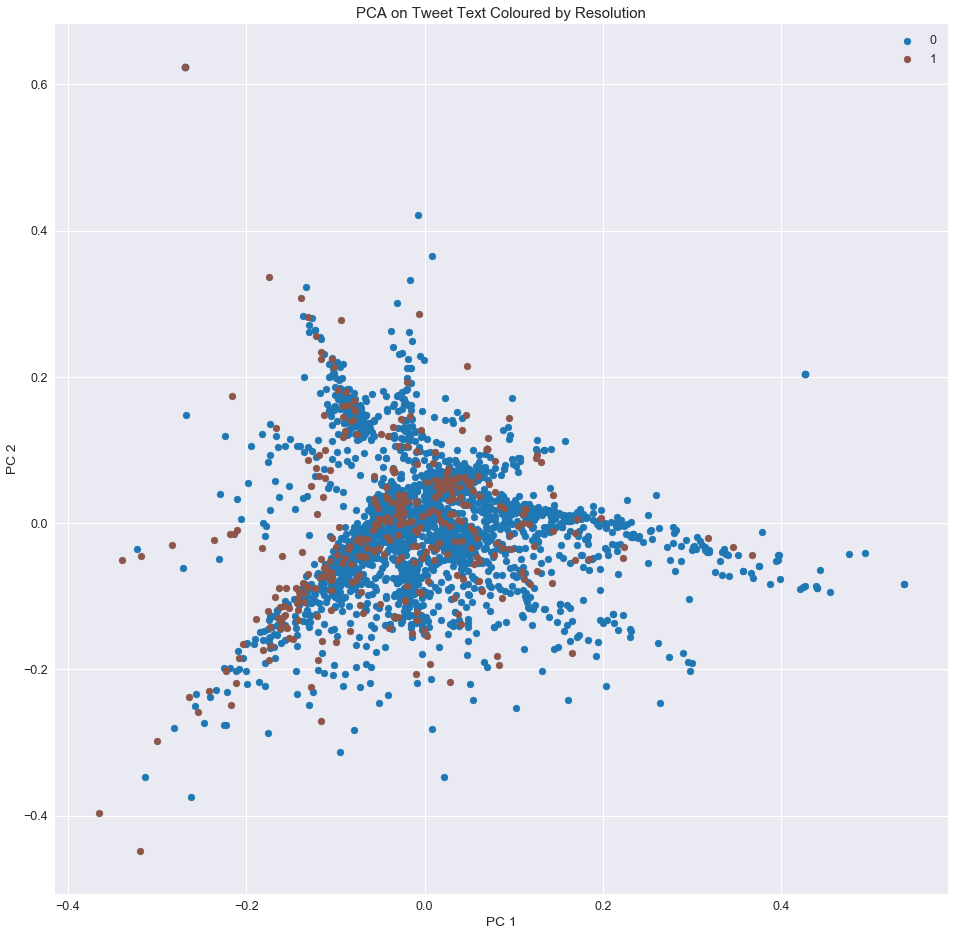

In [57]:
cNorm = Normalize(vmin=0, vmax=len(set(df['resolution'])))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
uniq = list(set(df['resolution']))

fig = plt.figure(figsize=(16,16))
for name, group in df.groupby('resolution'):
    plt.scatter(x=group['pc1'], y=group['pc2'], c=scalarMap.to_rgba(uniq.index(name)), label=name)
plt.title('PCA on Tweet Text Coloured by Resolution')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()
fig.savefig('PCA on Tweet Text Coloured by Resolution.jpg', bbox_inches='tight')

**Message Format**

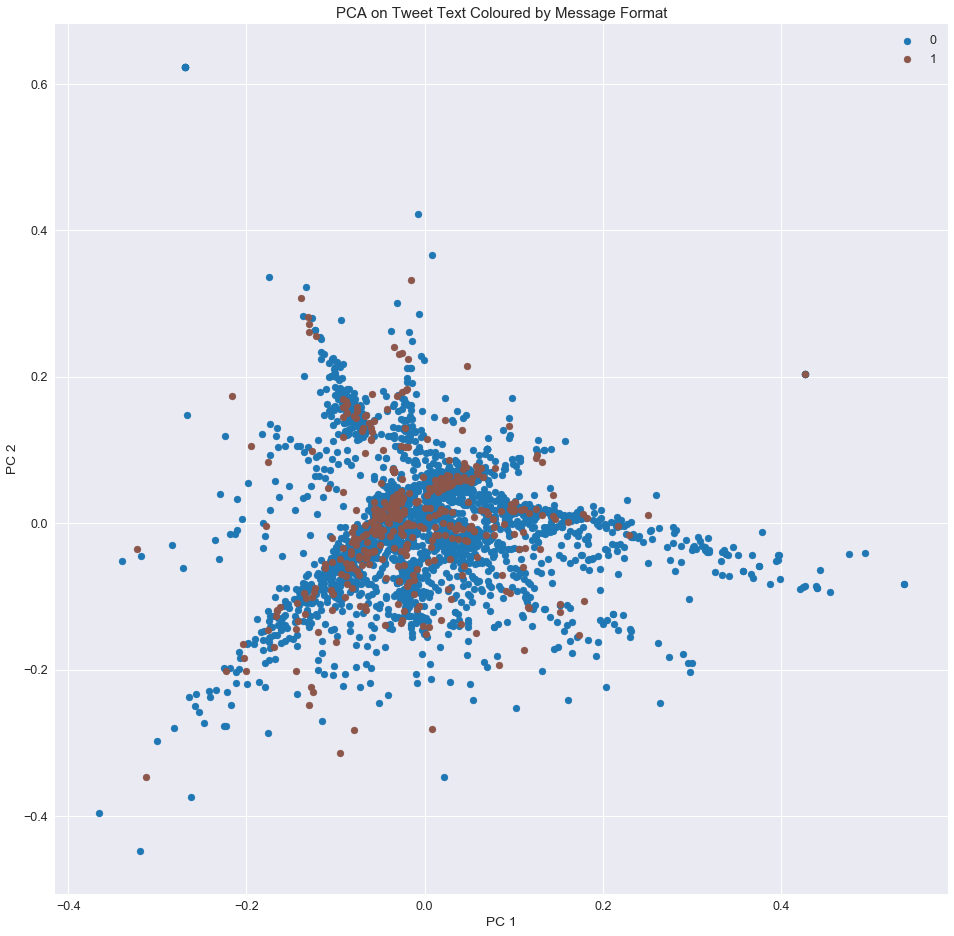

In [58]:
cNorm = Normalize(vmin=0, vmax=len(set(df['message_format'])))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
uniq = list(set(df['message_format']))

fig = plt.figure(figsize=(16,16))
for name, group in df.groupby('message_format'):
    plt.scatter(x=group['pc1'], y=group['pc2'], c=scalarMap.to_rgba(uniq.index(name)), label=name)
plt.title('PCA on Tweet Text Coloured by Message Format')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()
fig.savefig('PCA on Tweet Text Coloured by Message Format.jpg', bbox_inches='tight')

**Playfulness**

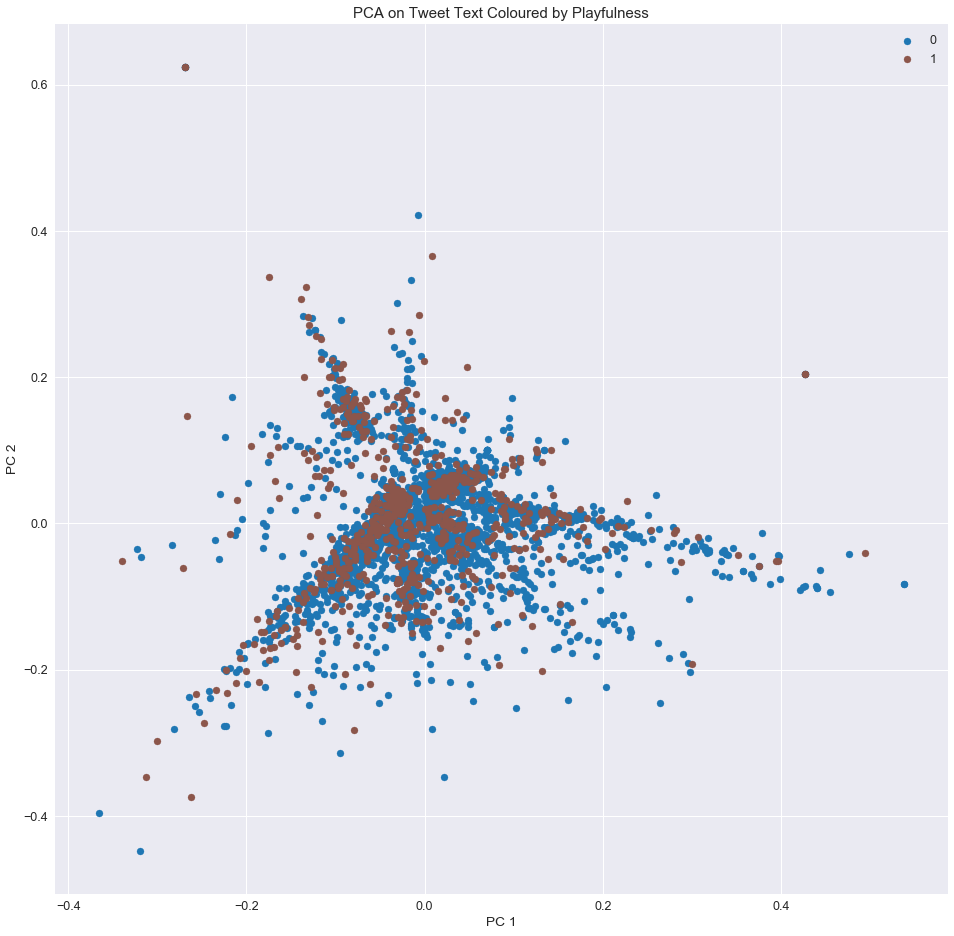

In [59]:
cNorm  = Normalize(vmin=0, vmax=len(set(df['playfulness'])))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
uniq = list(set(df['playfulness']))

fig = plt.figure(figsize=(16,16))
for name, group in df.groupby('playfulness'):
    plt.scatter(x=group['pc1'], y=group['pc2'], c=scalarMap.to_rgba(uniq.index(name)), label=name)
plt.title('PCA on Tweet Text Coloured by Playfulness')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()
fig.savefig('PCA on Tweet Text Coloured by Playfulness.jpg', bbox_inches='tight')

**Question**

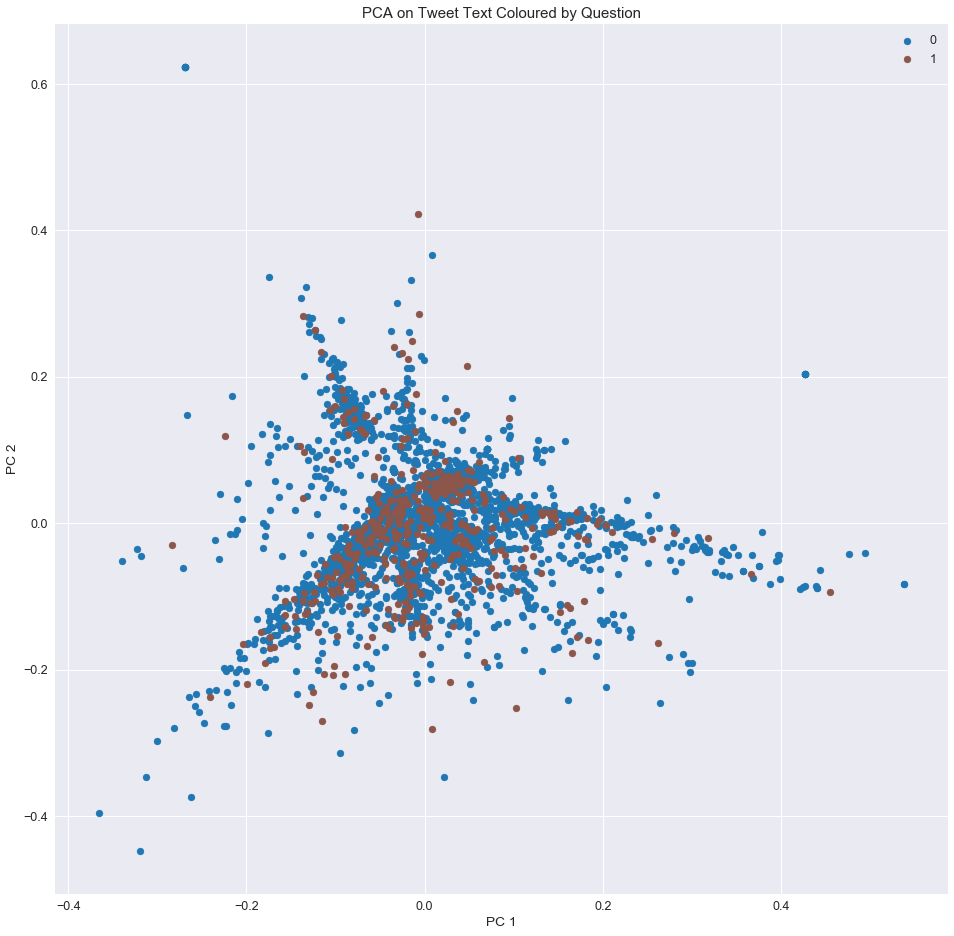

In [60]:
cNorm = Normalize(vmin=0, vmax=len(set(df['question'])))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
uniq = list(set(df['question']))

fig = plt.figure(figsize=(16,16))
for name, group in df.groupby('question'):
    plt.scatter(x=group['pc1'], y=group['pc2'], c=scalarMap.to_rgba(uniq.index(name)), label=name)
plt.title('PCA on Tweet Text Coloured by Question')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()
fig.savefig('PCA on Tweet Text Coloured by Question.jpg', bbox_inches='tight')

**Retweet Count (Binary)**

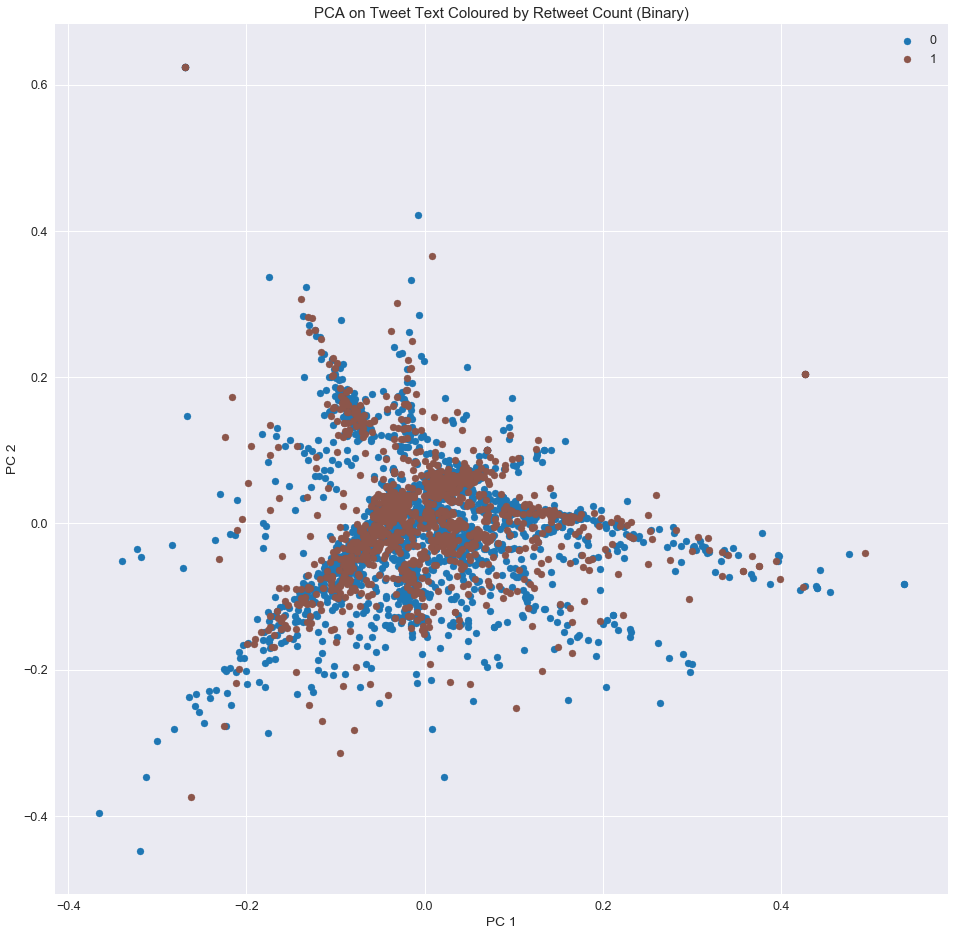

In [61]:
cNorm = Normalize(vmin=0, vmax=len(set(df['rt_count_binary'])))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
uniq = list(set(df['rt_count_binary']))

fig = plt.figure(figsize=(16,16))
for name, group in df.groupby('rt_count_binary'):
    plt.scatter(x=group['pc1'], y=group['pc2'], c=scalarMap.to_rgba(uniq.index(name)), label=name)
plt.title('PCA on Tweet Text Coloured by Retweet Count (Binary)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()
fig.savefig('PCA on Tweet Text Coloured by Retweet Count (Binary).jpg', bbox_inches='tight')

**Like Count (Binary)**

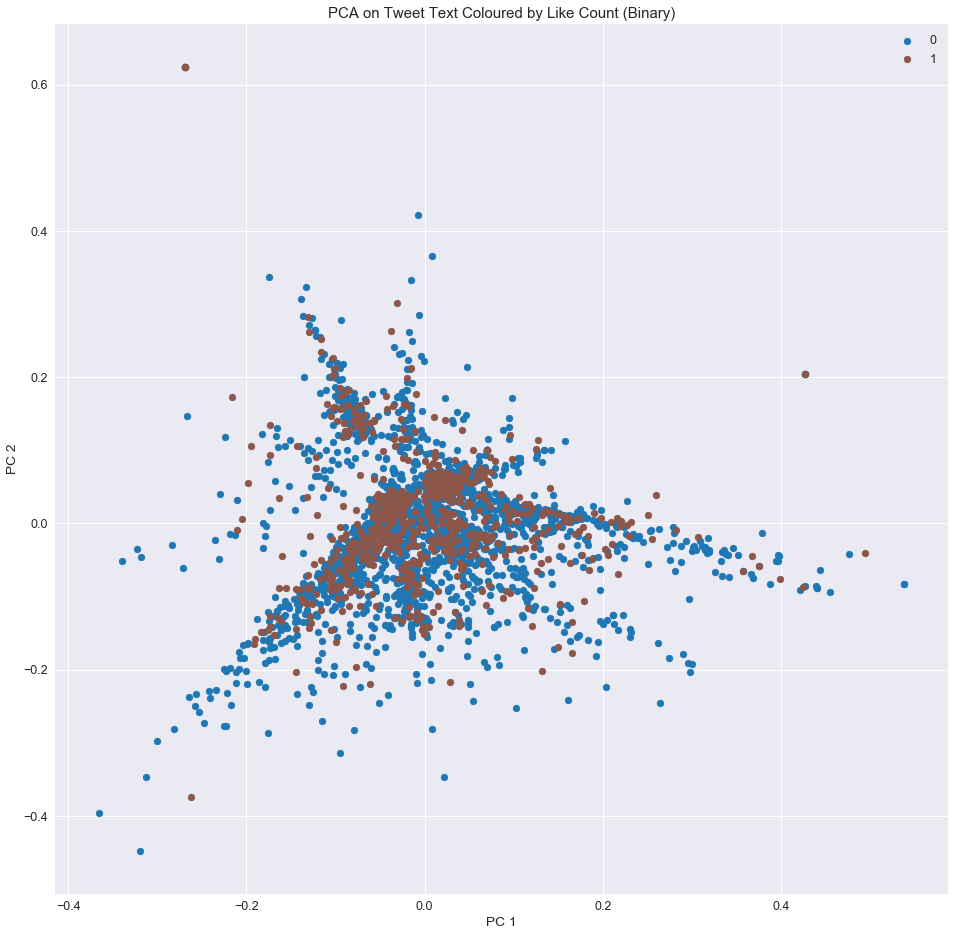

In [62]:
cNorm = Normalize(vmin=0, vmax=len(set(df['like_count_binary'])))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
uniq = list(set(df['like_count_binary']))

fig = plt.figure(figsize=(16,16))
for name, group in df.groupby('like_count_binary'):
    plt.scatter(x=group['pc1'], y=group['pc2'], c=scalarMap.to_rgba(uniq.index(name)), label=name)
plt.title('PCA on Tweet Text Coloured by Like Count (Binary)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()
fig.savefig('PCA on Tweet Text Coloured by Like Count (Binary).jpg', bbox_inches='tight')